## **YAP 101 Homework-7**  
Due Date: 30 March 2020 23:59

Send your files to m.torusdag@etu.edu.tr

The subject of your email should be "YAP101 HW7"

Total score is 105

In this homework, you will use the  forestfires.csv file which is uploaded on Piazza. Each row represents a forest fire in Portugal with several attributes and the area of the fire. Your task is to build a regression model that predicts the fire area. The columns in the file are as follows. 

    X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
    Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
    month - month of the year: 'jan' to 'dec'
    day - day of the week: 'mon' to 'sun'
    FFMC - FFMC index from the FWI system: 18.7 to 96.20
    DMC - DMC index from the FWI system: 1.1 to 291.3
    DC - DC index from the FWI system: 7.9 to 860.6
    ISI - ISI index from the FWI system: 0.0 to 56.10
    temp - temperature in Celsius degrees: 2.2 to 33.30
    RH - relative humidity in %: 15.0 to 100
    wind - wind speed in km/h: 0.40 to 9.40
    rain - outside rain in mm/m2 : 0.0 to 6.4
    area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).


In [1]:
# Run this cell first
from datascience import * 
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from scipy.stats import pearsonr
import numpy as np

**Question 1 (5 Points)**. Load the data. We want to use the first 80% of the data for training and the last 20% for testing. 

In [6]:
data=Table.read_table('forestfires.csv')
month_class=data.select('month').group('month').column('month')
day_class=data.select('day').group('day').column('day')

In [10]:
data

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18,33,0.9,0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0,0
8,6,mar,fri,91.7,33.3,77.5,9,8.3,97,4,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0,0
8,6,aug,sun,92.3,85.3,488,14.7,22.2,29,5.4,0,0
8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0,0
8,6,aug,mon,91.5,145.4,608.2,10.7,8,86,2.2,0,0
8,6,sep,tue,91,129.5,692.6,7,13.1,63,5.4,0,0
7,5,sep,sat,92.5,88,698.6,7.1,22.8,40,4,0,0


In [13]:
data2 = data
for i in np.arange(0,len(month_class)):
    labels = np.zeros(len(month_class))
    labels[i] = 1
    tmp_table = Table().with_columns('class',month_class,month_class[i],labels)
    data2 = data2.join('month',tmp_table,'class')

for i in np.arange(0,len(day_class)):
    labels = np.zeros(len(day_class))
    labels[i] = 1
    tmp_table = Table().with_columns('class',day_class,day_class[i],labels)
    data2 = data2.join('day',tmp_table,'class')
    
data2 = data2.drop('month','day')
data2.show(3)

X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed
4,4,83,23.3,85.3,2.3,16.7,20,3.1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,5,63.5,70.8,665.3,0.8,17,72,6.7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,90.1,108,529.8,12.5,14.7,66,2.7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [18]:
train,test=data2.split(int(data.num_rows*0.8))

**Question 2 (15 Points)** Build a linear regression model to predict area of forest fires using all features. Print the weigths of each feature and bias value.

In [17]:
def predict_price(weights, bias, x):
    return sum(weights*x) + bias

In [19]:
train_areas = train.column('area')  #array
train_features = train.drop('area')  #table

In [20]:
def rmse(weights, bias, features, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict_price(weights,bias, np.array(features.row(i)))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

In [23]:
def rmse_train(weights):
    return rmse(weights[0:len(weights)-1],weights[len(weights)-1], train_features, train_areas)

In [24]:
initial_weights = np.ones( len(train_features.row(0) )+1)

#minimize fonksyonu ile elde edilen weightler
learned_weights = minimize(rmse_train, start=initial_weights, smooth=True, array=True)

print('The best slopes for the training set:')
features_names = np.append(train_features.labels,'bias')
Table(features_names).with_row(list(learned_weights)).show()

print('RMSE of all training examples using the best slopes:', rmse_train(learned_weights))

The best slopes for the training set:


X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed,bias
2.75341,0.0435671,0.21177,0.229855,-0.146933,-0.472837,1.10813,-0.235157,1.7195,-2.45874,-31.5072,27.8959,24.3832,-17.1299,-26.9405,13.6388,-19.8975,-32.2866,-13.0747,-26.7657,51.288,58.0695,-6.34157,1.07384,16.0532,-5.82395,5.49572,-1.20193,-6.56449,-3.32168


RMSE of all training examples using the best slopes: 67.82695528679277


**Question 3 (15 Points)** We want to know which feautures are correlated each other. Calculate pearson correlation between each feature pair. Print the results in a matrix format (the diagonals should be 1).

In [40]:
Matrix = [[pearsonr(train_features.column(i),train_features.column(j))[0] for i in np.arange(len(train_features.labels))] for j in np.arange(len(train_features.labels))]
matrix_table=Table(train_features.labels)

for i in np.arange(len(train_features.labels)):
    matrix_table=matrix_table.with_row(list(Matrix[i]))


In [42]:
matrix_table.show()

X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed
1,0.530113,-0.0357917,-0.0103306,-0.0772409,-0.0241371,-0.0669356,0.0993985,0.0403303,0.0809352,0.0780156,-0.0350897,0.00854172,0.0363699,-0.0538299,0.0514758,0.108693,0.00545336,0.0157337,0.0327592,0.0901702,-0.103218,-0.0505909,0.036501,0.0169414,-0.0600415,-0.0117728,0.0148926,0.0697063
0.530113,1,-0.0260394,0.0486021,-0.0758083,-0.0159348,-0.0167555,0.0508049,0.0191882,0.0419085,0.0146118,0.0262867,0.0739206,-0.0511023,-0.0104705,0.0607627,0.0970676,0.0481744,-0.0148255,-0.0520503,-0.0351559,-0.110605,-0.0761121,0.0173001,0.01034,-0.028835,0.0193415,-0.00362522,0.0806525
-0.0357917,-0.0260394,1,0.396743,0.360603,0.64644,0.456054,-0.252286,-0.104632,0.0713877,-0.163959,0.270168,-0.166887,-0.335407,-0.0886557,0.0162477,-0.0760959,-0.0995258,-0.0492187,-0.115347,-0.00249694,0.0638747,0.00252989,-0.107021,-0.0516326,-0.0120804,0.0588916,0.00471689,0.126117
-0.0103306,0.0486021,0.396743,1,0.695748,0.334986,0.465616,0.121964,-0.150409,0.0806306,-0.209151,0.501085,-0.18765,-0.296502,-0.0827246,0.0186327,-0.0557266,-0.424646,-0.0923705,-0.0832568,-0.178424,0.10278,-0.0466028,-0.147485,-0.0115224,0.0759467,0.119571,-0.00239231,0.0234951
-0.0772409,-0.0758083,0.360603,0.695748,1,0.310284,0.49979,-0.0134172,-0.250767,0.0403531,-0.280427,0.298465,-0.110946,-0.364331,-0.106655,-0.0929711,-0.169593,-0.669985,-0.1273,-0.087337,0.0913372,0.51514,-0.0419475,-0.0694226,-0.0340239,0.0398968,0.0765573,0.0145859,0.0271583
-0.0241371,-0.0159348,0.64644,0.334986,0.310284,1,0.445814,-0.112952,0.0722512,0.0828252,-0.154585,0.406754,-0.204334,-0.271685,-0.0734151,0.030646,-0.00203346,-0.166378,-0.0752487,-0.0948784,-0.0586931,-0.0634771,0.0358406,-0.207271,-0.0612626,-0.0199006,-0.0398958,0.117036,0.192392
-0.0669356,-0.0167555,0.456054,0.465616,0.49979,0.445814,1,-0.504178,-0.271139,0.0776373,-0.167427,0.358701,-0.343335,-0.283579,-0.113535,0.101167,0.0547469,-0.347079,-0.0496912,-0.0590041,-0.0600881,0.0990467,-0.0848638,-0.172171,0.0231741,0.0464547,0.0575197,0.0288741,0.118706
0.0993985,0.0508049,-0.252286,0.121964,-0.0134172,-0.112952,-0.504178,1,0.0909023,0.11148,0.0368351,0.0820644,-0.0710807,0.128199,0.101809,0.0670063,0.023643,-0.13213,0.0970196,-0.0404261,-0.0581417,-0.0785573,0.0929878,0.025168,-0.0418563,0.105211,-0.117033,-0.00103725,-0.101873
0.0403303,0.0191882,-0.104632,-0.150409,-0.250767,0.0722512,-0.271139,0.0909023,1,0.0671714,0.000227605,-0.0145695,0.27723,0.0296249,-0.0272623,-0.00313241,0.0183326,0.200124,0.0150032,0.0119981,-0.0119299,-0.21494,0.134428,-0.0432394,-0.0802966,-0.00783063,-0.0566211,0.0547967,-0.0141027
0.0809352,0.0419085,0.0713877,0.0806306,0.0403531,0.0828252,0.0776373,0.11148,0.0671714,1,-0.0115292,0.100324,-0.0115292,-0.0153659,-0.0040414,-0.0141144,-0.0141905,-0.0243858,-0.00572235,-0.0040414,-0.0135695,-0.056223,-0.00680581,-0.0324893,-0.0364188,-0.0188099,-0.0283265,0.150679,-0.0243858


**Question 4 (5 Points)** Calculate Pearson correlation of each feature with the forest fire area.

In [49]:
labels = data2.drop('area').labels
r_values=[]
for i in np.arange(len(labels)):
    r_values.append(pearsonr(data2.column('area'),data2.column(labels[i] ))[0])
    
corr_table=Table().with_columns('Labels',labels,'Pearsonr',r_values) 
corr_table

Labels,Pearsonr
X,0.0633853
Y,0.0448732
FFMC,0.040122
DMC,0.0729943
DC,0.0493832
ISI,0.00825769
temp,0.0978441
RH,-0.0755186
wind,0.0123173
rain,-0.00736573


**Question 5 (15 Points)Feature Selection** We want to use 5 features which have the highest orrelation with the forest fire area. However, we do not want to use any correlated feature such that no feature pair in these selected features should have a correlation higher than 0.5 or less than -0.5. If there is such a pair, remove the  feature which is less correlated with forest fire area and pick the feature which has the most correlation with the fire area among all other previosuly not selected features. Eventually you should have 5 features.

In [129]:
corr_first5=corr_table.with_columns('abs',abs(corr_table.column('Pearsonr'))).sort('abs',descending=True).take(np.arange(6))
corr_first5

Labels,Pearsonr,abs
temp,0.0978441,0.0978441
sat,0.0878676,0.0878676
RH,-0.0755186,0.0755186
DMC,0.0729943,0.0729943
X,0.0633853,0.0633853
sep,0.0565729,0.0565729


In [116]:
def find_correlation(column1,column2):
    return matrix_table[matrix_table.column_index(column1)][matrix_table.column_index(column2)]

In [123]:
for column1 in corr_first5.column(0):
    for column2 in corr_first5.column(0):
        print (column1 + ", "+ column2 +", " + str(find_correlation(column1,column2)))

temp, temp, 1.0
temp, sat, 0.023174109691778983
temp, RH, -0.5041782189597932
temp, DMC, 0.4656158030272235
temp, X, -0.06693564998504759
temp, sep, 0.09904670950618465
sat, temp, 0.023174109691778983
sat, sat, 1.0
sat, RH, -0.04185629794255413
sat, DMC, -0.011522378934034651
sat, X, 0.016941405404874908
sat, sep, -0.02427218607648703
RH, temp, -0.5041782189597932
RH, sat, -0.04185629794255413
RH, RH, 1.0
RH, DMC, 0.12196375031833154
RH, X, 0.09939850480789052
RH, sep, -0.07855725106077827
DMC, temp, 0.4656158030272235
DMC, sat, -0.011522378934034651
DMC, RH, 0.12196375031833154
DMC, DMC, 1.0
DMC, X, -0.010330639455733061
DMC, sep, 0.10278033298783745
X, temp, -0.06693564998504759
X, sat, 0.016941405404874908
X, RH, 0.09939850480789052
X, DMC, -0.010330639455733061
X, X, 1.0
X, sep, -0.10321780407952001
sep, temp, 0.09904670950618465
sep, sat, -0.02427218607648703
sep, RH, -0.07855725106077827
sep, DMC, 0.10278033298783745
sep, X, -0.10321780407952001
sep, sep, 1.0


In [125]:
#RH,temps values is lower than -0.5 so it is removed.

In [130]:
corr_first5=corr_first5.remove(2)
corr_first5

Labels,Pearsonr,abs
temp,0.0978441,0.0978441
sat,0.0878676,0.0878676
DMC,0.0729943,0.0729943
X,0.0633853,0.0633853
sep,0.0565729,0.0565729


**Question 6 (15 Points)** Build a linear regression model using the features selected in Question 5. Print the weigths of each feature and bias value.

In [70]:
train_features_5=train.drop('area').select(corr_first5.column(0))
train_features_5.show(3)

temp,sat,DMC,X,sep
22.7,0,108.4,8,1
17.8,1,43.7,7,0
14.2,1,253.6,8,0


In [71]:
def rmse_train_with5(weights):
    return rmse(weights[0:len(weights)-1],weights[len(weights)-1], train_features_5, train_areas)

In [72]:
initial_weights_with5 = np.ones( len(train_features_5.row(0) )+1)
learned_weights_with5 = minimize(rmse_train_with5, start=initial_weights_with5, smooth=True, array=True)
print('The best slopes for the training set:')
features_names_with5 = np.append(train_features_5.labels,'bias')
Table(features_names_with5).with_row(list(learned_weights_with5)).show()
print('RMSE of all training examples using the best slopes:', rmse_train_with5(learned_weights_with5))

The best slopes for the training set:


temp,sat,DMC,X,sep,bias
0.935529,19.5177,0.0379566,2.61656,9.6117,-26.5263


RMSE of all training examples using the best slopes: 68.6484051543383


**Question 7 (10 Points)**  Calculate root mean square error value of your models in Question 2 and Question 6 on your test data.

In [82]:
test_area = test.column('area')
test_features_Q2 = test.drop('area')
test_features_Q6=test.select(corr_first5.column(0))

In [83]:
def rmse_test(weights,feature):
    return rmse(weights[0:len(weights)-1],weights[len(weights)-1], feature, test_area)

In [93]:
print('RMSE score of Q2 Model: '+ str(rmse_test(learned_weights,test_features_Q2)))
print('RMSE score of Q6 Model: '+ str(rmse_test(learned_weights_with5,test_features_Q6)))


RMSE score of Q2 Model: 32.41440979591175
RMSE score of Q6 Model: 30.355589615542293


**Question 8 (5 Points)** Plot the test data where x axis is the actual forest fire area and y axis is the predicted values by the model in Question 2 and Question 6. The colors for each model should be different. 

In [134]:
bias_Q2 = learned_weights[len(learned_weights)-1]
bias_Q6 = learned_weights_with5[len(learned_weights_with5)-1]
def predict_Q2(row):
    return sum(learned_weights[0:len(learned_weights)-1] * np.array(row)) + bias_Q2
def predict_Q6(row):
    return sum(learned_weights_with5[0:len(learned_weights_with5)-1] * np.array(row)) + bias_Q6

In [137]:
with_prediction=test.with_columns('Prediction_Q2', test.drop('area').apply(predict_Q2),'Prediction_Q6',test.select(corr_first5.column(0)).apply(predict_Q6))

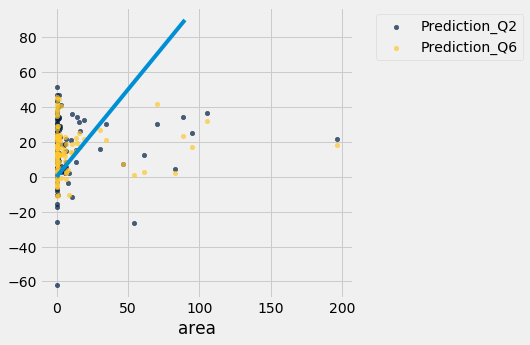

In [142]:
with_prediction.select('area','Prediction_Q2','Prediction_Q6').scatter('area')
plots.plot([0,9e1],[0,9e1])

**Question 9(20 Points)K-fold**. Build a knn model for this problem where the predicted area is the mean of the closest 3 neighbors. Calculate RMSE score for this model on your test data.

In [98]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))
def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))
def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)
def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))

In [103]:
def predict_knn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train, example, 3, 'area').column('area'))

In [105]:
prediction_with_knn = test.drop('area').apply(predict_knn)
rmse_knn = np.mean((test_area - prediction_with_knn) ** 2) ** 0.5
rmse_linear=rmse_test(learned_weights,test_features_Q2)
print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_knn)

Test set RMSE for multiple linear regression:  32.41440979591175
Test set RMSE for nearest neighbor regression: 38.81583225507146
